# **Clustering - Mall Customer Segmentation**

Clustering adalah sebuah proses untuk mengelompokan data ke dalam beberapa cluster
atau kelompok sehingga data dalam satu cluster memiliki tingkat kemiripan yang maksimum
dan data antar cluster memiliki kemiripan yang minimum.Clustering merupakan metode
segmentasi data yang sangat berguna dalam prediksi dan analisa masalah bisnis tertentu.
Misalnya Segmentasi pasar, marketing dan pemetaan zonasi wilayah

Dataset pelanggan yang akan digunakan terdiri dari variabel dibawah ini :

1. CustomerID: ID customer (dalam dataset ini merupakan angka yang berurutan)
2. Gender: jenis kelamin konsumen
3. Age: umur konsumen
4. Annual Income(k$): pendapatan dari konsumen 
5. Spending Score:  skor (dari 1-100) yang diberikan kepada pelanggan oleh otoritas mal, berdasarkan uang yang dikeluarkan dan perilaku pelanggan.

Source: https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python


## **Install and Import Libraries**

***Install Library***

In [1]:
# Install Category Encoders
! pip install category_encoders

     |████████████████████████████████| 81kB 2.0MB/s 


In [2]:
!pip install kneed 
from kneed import DataGenerator, KneeLocator 

***Import Libraries***

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import matplotlib.cm as cm
from scipy import stats

import os
import warnings
warnings.filterwarnings("ignore")

## **Import Data**

***Mall Customer Data***

In [4]:
# Import Data to Google Colab
df_customer = pd.read_csv('https://raw.githubusercontent.com/amaliaristantya/Digital_Talent_Incubator/main/Clustering/Mall_Customer.csv', sep = ';')
df_customer

,customer,gender,age,ann_income_kUSD,spending_score
0,1,male,19,15,39
1,2,male,21,15,81
2,3,female,20,16,6
3,4,female,23,16,77
4,5,female,31,17,40
...,...,...,...,...,...
195,196,female,35,120,79
196,197,female,45,126,28
197,198,male,32,126,74
198,199,male,32,137,18


In [5]:
# Prints the Dataset Information
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   customer         200 non-null    int64 
 1   gender           200 non-null    object
 2   age              200 non-null    int64 
 3   ann_income_kUSD  200 non-null    int64 
 4   spending_score   200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


Dataset terdiri dari 200 baris dan 5 kolom, dengan tipe data object dan integer

Ubah nama kolom agar mempermudah pemanggilan 

In [6]:
#rename head of Dataset 
df_customer.rename(index=str, columns={'ann_income_kUSD': 'income',
                              'spending_score': 'score'}, inplace=True)
df_customer.head()

,customer,gender,age,income,score
0,1,male,19,15,39
1,2,male,21,15,81
2,3,female,20,16,6
3,4,female,23,16,77
4,5,female,31,17,40


In [7]:
# Prints Descriptive Statistics
df_customer.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
customer,200.0,100.50,57.879185,1.0,50.75,100.5,150.25,200.0
age,200.0,38.85,13.969007,18.0,28.75,36.0,49.00,70.0
income,200.0,60.56,26.264721,15.0,41.50,61.5,78.00,137.0
score,200.0,50.20,25.823522,1.0,34.75,50.0,73.00,99.0


Pada kolom count menunjukan bahwa masing-masing jumlah baris yaitu 200 (tidak ada yang null) dan dapat dianalisis bahwa :



1.   customer/customer ID  : tidak dianalisis karena hanya berupa urutan angka sehingga tidak mempunyai makna
2.  age : rata-rata umur pelanggan yaitu 38/39 tahun. Dengan pelanggan termuda yaitu usia 18 tahun dan pelanggan paling tua berumur 70 tahun
3. income : rata-rata pendapatan pelanggan yaitu 60.56 dolar , dengan pendapatan terendah 15 dolar dan tertinggi 137 dolar
4. score : rata-rata pengeluaran pelanggan yaitu 50.20 skor, dengan pengeluaran terendah 1 skor dan tertinggi 99 skor





## **Explore the Dataset**

Data dikelompokkan berdasarkan jenis kelamin - satu-satunya variabel kategori.

In [8]:
# subset with males age
males_age = df_customer[df_customer['gender']=='male']['age']
# subset with females age 
females_age = df_customer[df_customer['gender']=='female']['age']
age_bins = range  (15,75,5)

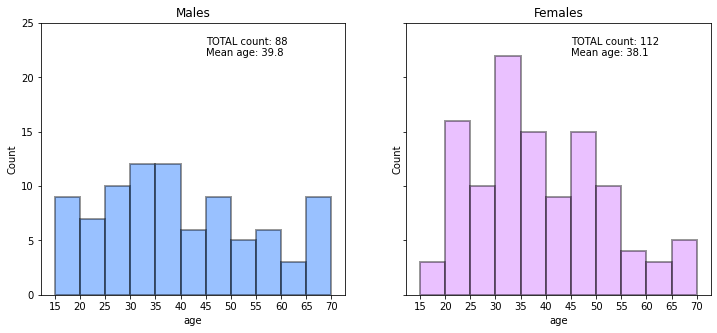

In [9]:
#males Histogram 
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharey=True)
sns.distplot(males_age, bins=age_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(age_bins)
ax1.set_ylim(top=25)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(45,23, "TOTAL count: {}".format(males_age.count()))
ax1.text(45,22, "Mean age: {:.1f}".format(males_age.mean()))

# female Histogram 
sns.distplot(females_age, bins=age_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(age_bins)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(45,23, "TOTAL count: {}".format(females_age.count()))
ax2.text(45,22, "Mean age: {:.1f}".format(females_age.mean()))

plt.show()


Usia rata-rata pelanggan pria sedikit lebih tinggi daripada pelanggan wanita (39,8 berbanding 38,1). Distribusi umur pria lebih rata dibandingkan wanita, dimana terlihat bahwa kelompok umur terbesar adalah 30-35 tahun.

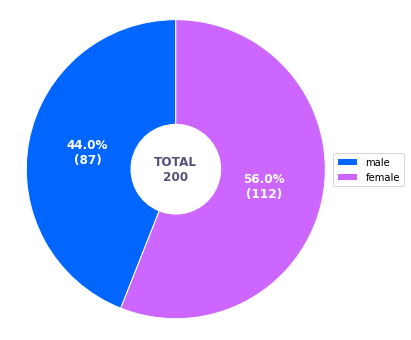

In [11]:
def labeler(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

sizes = [males_age.count(),females_age.count()] # wedge sizes

fig0, ax1 = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax1.pie(sizes,
                                   autopct=lambda pct: labeler(pct, sizes),
                                   radius=1,
                                   colors=['#0066ff','#cc66ff'],
                                   startangle=90,
                                   textprops=dict(color="w"),
                                   wedgeprops=dict(width=0.7, edgecolor='w'))

ax1.legend(wedges, ['male','female'],
           loc='center right',
           bbox_to_anchor=(0.7, 0, 0.5, 1))

plt.text(0,0, 'TOTAL\n{}'.format(df_customer['age'].count()),
         weight='bold', size=12, color='#52527a',
         ha='center', va='center')

plt.setp(autotexts, size=12, weight='bold')
ax1.axis('equal')  # Equal aspect ratio
plt.show()

pelanggan wanita lebih banyak dibandingkan dengan pria dengan perbandingan 56 : 44

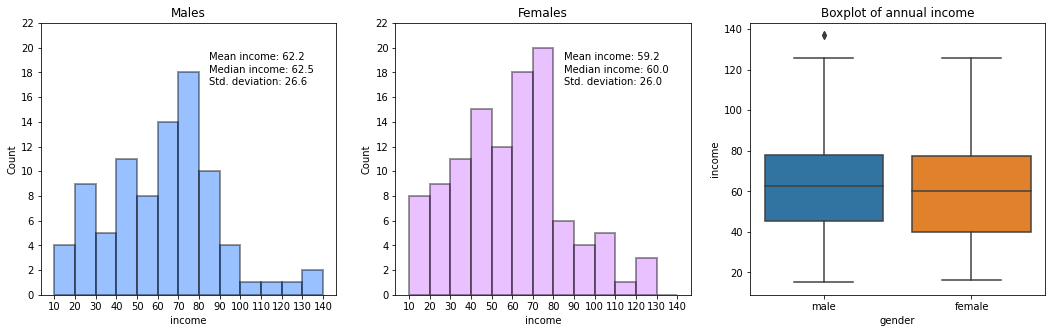

In [12]:
males_income = df_customer[df_customer['gender']=='male']['income'] # subset with males income
females_income = df_customer[df_customer['gender']=='female']['income'] # subset with females income

my_bins = range(10,150,10)

# males histogram
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
sns.distplot(males_income, bins=my_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(my_bins)
ax1.set_yticks(range(0,24,2))
ax1.set_ylim(0,22)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(85,19, "Mean income: {:.1f}".format(males_income.mean()))
ax1.text(85,18, "Median income: {:.1f}".format(males_income.median()))
ax1.text(85,17, "Std. deviation: {:.1f}".format(males_income.std()))

# females histogram
sns.distplot(females_income, bins=my_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(my_bins)
ax2.set_yticks(range(0,24,2))
ax2.set_ylim(0,22)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(85,19, "Mean income: {:.1f}".format(females_income.mean()))
ax2.text(85,18, "Median income: {:.1f}".format(females_income.median()))
ax2.text(85,17, "Std. deviation: {:.1f}".format(females_income.std()))

# boxplot
sns.boxplot(x='gender', y='income', data=df_customer, ax=ax3)
ax3.set_title('Boxplot of annual income')
plt.show()

mean income lebih tinggi daripada wanita 62,2 vs. 59,2.  median income pelanggan pria lebih tinggi daripada wanita 62,5 vs. 60

Simpangan baku serupa untuk kedua kelompok. Bedasarkan bloxplot,ada 1 kelompok pria dengan pendapatan tahunan sekitar 140 (outlier). 

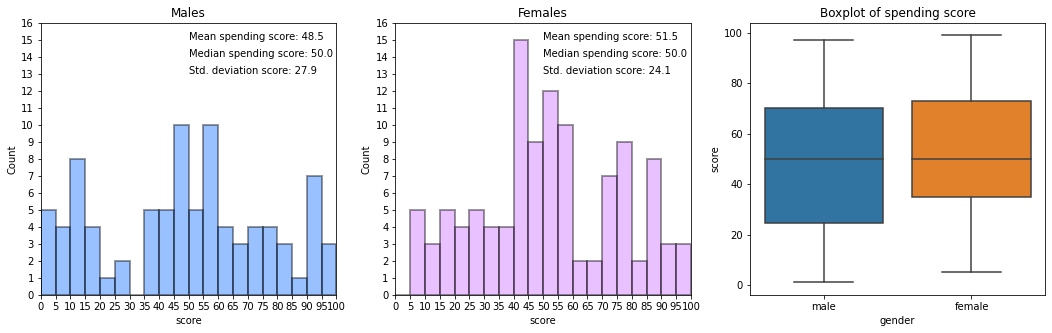

In [14]:
males_spending = df_customer[df_customer ['gender']=='male']['score'] # subset with males age
females_spending = df_customer[df_customer['gender']=='female']['score'] # subset with females age

spending_bins = range(0,105,5)

# males histogram
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
sns.distplot(males_spending, bins=spending_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(spending_bins)
ax1.set_xlim(0,100)
ax1.set_yticks(range(0,17,1))
ax1.set_ylim(0,16)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(50,15, "Mean spending score: {:.1f}".format(males_spending.mean()))
ax1.text(50,14, "Median spending score: {:.1f}".format(males_spending.median()))
ax1.text(50,13, "Std. deviation score: {:.1f}".format(males_spending.std()))

# females histogram
sns.distplot(females_spending, bins=spending_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(spending_bins)
ax2.set_xlim(0,100)
ax2.set_yticks(range(0,17,1))
ax2.set_ylim(0,16)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(50,15, "Mean spending score: {:.1f}".format(females_spending.mean()))
ax2.text(50,14, "Median spending score: {:.1f}".format(females_spending.median()))
ax2.text(50,13, "Std. deviation score: {:.1f}".format(females_spending.std()))

# boxplot
sns.boxplot(x='gender', y='score', data=df_customer, ax=ax3)
ax3.set_title('Boxplot of spending score')
plt.show()

plt.show()

Rata-rata skor pengeluaran untuk wanita (51.5) lebih tinggi daripada pria (48.5)

In [16]:
#Calculate The Median Income for all age groups 
medians_by_age_group = df_customer.groupby(["gender",pd.cut(df_customer['age'], age_bins)]).median()
medians_by_age_group.index = medians_by_age_group.index.set_names(['gender', 'age_group'])
medians_by_age_group.reset_index(inplace=True)

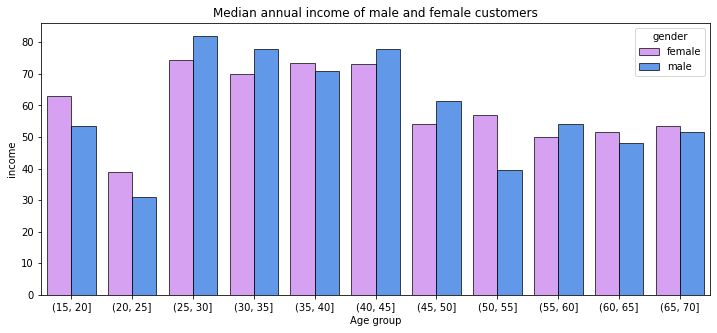

In [17]:
fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(x='age_group', y='income', hue='gender', data=medians_by_age_group,
            palette=['#cc66ff','#0066ff'],
            alpha=0.7,edgecolor='k',
            ax=ax)
ax.set_title('Median annual income of male and female customers')
ax.set_xlabel('Age group')
plt.show()

Pelanggan dengan pendapatan paling tinggi berapa pada rentang usia 25-45 tahun. Perbedaan terbesar antara wanita dan pria terlihat pada kelompok usia (50,55) dimana wanita lebih banyak penghasilannya dibandingkan pria, padahal pada histogram sebelumnya terapat fakta bahwa rata-rata penghasilan pria lebih tinggi dibandingkan wanita.

## CLUSTERING

***Visualize Data using Pairplot***

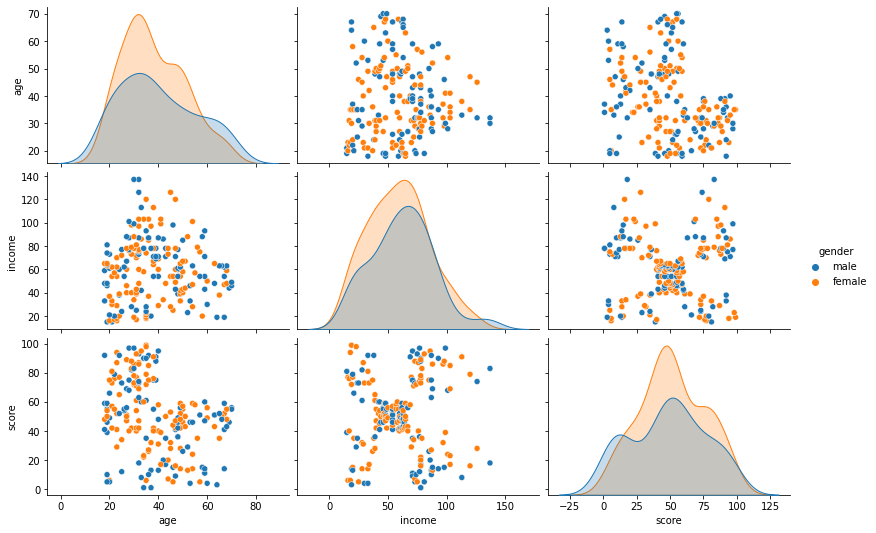

In [18]:
# Let's see our data in a detailed way with pairplot
X = df_customer.drop(['customer', 'gender'], axis=1)
sns.pairplot(df_customer.drop('customer', axis=1), hue='gender', aspect=1.5)
plt.show()

Jika kita lihat pada gambar, maka antara warna biru dan orange (menunjukan age) tidak ada persebaran yang spesifik dan cenderung tercampur satu sama lain. Hal ini mengidentifikasikan bahwa dengan variabel age tidak didapat hasil klasifikasi yang tepat atau optimal. maka drop variabel age untuk pemodelan klasifikasi.

***Visualize Data using Scatterplot***

Text(413.30440104166667, 0.5, 'Spending Score')

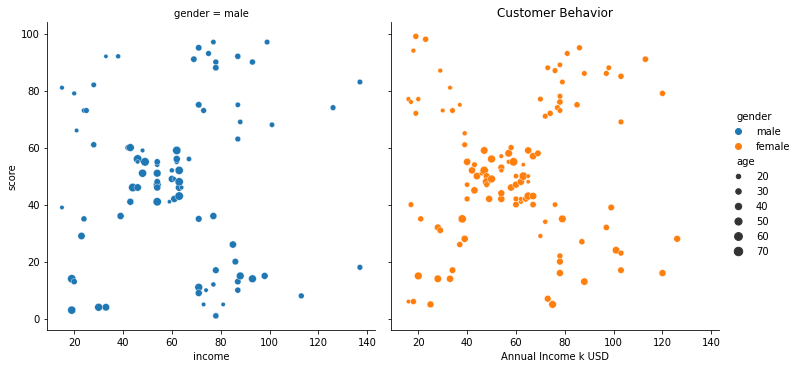

In [19]:
# Draw Scatter Plot
sns.relplot(x='income', y='score', hue='gender', size='age', kind='scatter', col='gender', data=df_customer)
plt.title('Customer Behavior')
plt.xlabel('Annual Income k USD')
plt.ylabel('Spending Score')

Plot diatas menunjukan hubungan antara annual income, spending score dan gender pelanggan. Semakin besar plot maka usia pelanggan semakin tinggi.

***Visualize Correlation between Features***

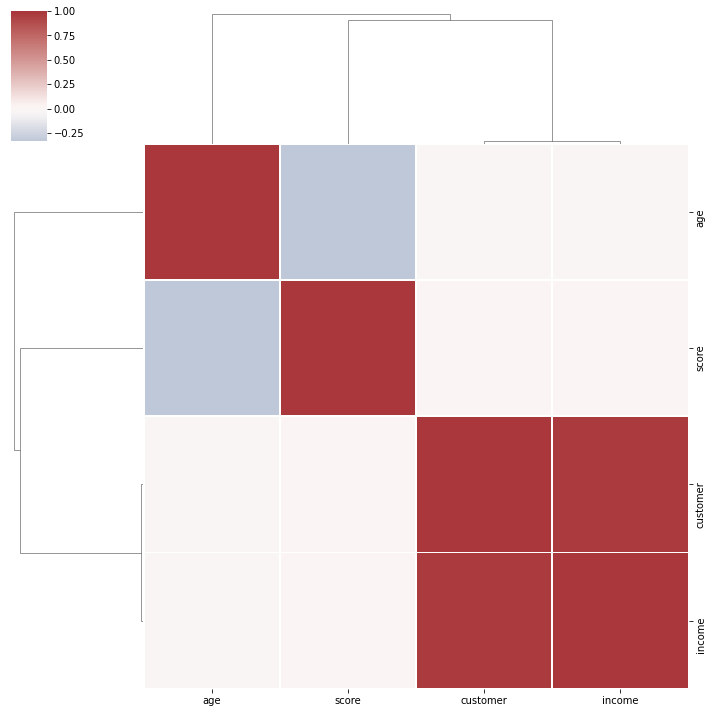

In [20]:
# Draw Correlation to see hierarchically clustered heatmap
sns.clustermap(df_customer.corr(), center=0, cmap='vlag', linewidths=.75)

* Dari heatmap diatas variabel gender telah didrop karena pada 
visualisasi sebelumnya telah didapatkan indikasi bahwa tidak ada korelasi dengan variabel lain.
* Untuk variabel customer akan kita drop karena hanya berisi urutan angka saja.
* Jika dilihat pada heatmap maka belum terlihat bagaimana korelasi yang kuat antarr variabel. Makakita akan menggunakan pertimbangan 3 variabel yaitu score, age, income
* variabel y = score, x1 = age, x2=income

## **Data Preprocessing**

***Handling Missing Values***

In [21]:
# Check for Missing Values
df_customer.isnull().sum()

customer    0
gender      0
age         0
income      0
score       0
dtype: int64

In [22]:
#datashape ( we have 200 list of data with 5 data head)
df_customer.shape


(200, 5)

In [23]:
#selecting feature (use iloc iloc as integer index-based. So here, we have to specify rows and columns by their integer index.)
# 3 column of income, 4 column of score 
X_numerics = df_customer.iloc[:,[3,4]].values 

In [24]:
Z_numerics = df_customer[['income', 'score']] # subset with numerical only

In [25]:
Z_numerics

,income,score
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40
...,...,...
195,120,79
196,126,28
197,126,74
198,137,18


## K-MEANS 

K-Means Clustering adalah suatu metode penganalisaan data atau metode Data
Mining yang melakukan proses pemodelan tanpa supervisi (unsupervised) dan
merupakan salah satu metode yang melakukan pengelompokan data dengan
sistem partisi.

In [26]:
from sklearn.metrics import silhouette_score
n_clusters = [2,3,4,5,6,7,8,9,10] # number of clusters
clusters_inertia = [] # inertia of clusters
s_scores = [] # silhouette scores

for n in n_clusters:
    KM_est = KMeans(n_clusters=n, init='k-means++').fit(Z_numerics)
    clusters_inertia.append(KM_est.inertia_)    # data for the elbow method
    silhouette_avg = silhouette_score(Z_numerics, KM_est.labels_)
    s_scores.append(silhouette_avg) # data for the silhouette score method

In [27]:
#Determine the optimal number of cluster 
# Elbow Method
from sklearn.cluster import KMeans
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(Z_numerics)
    wcss.append(kmeans.inertia_)
kl = KneeLocator(
    range(1,11), wcss, curve="convex", direction= "decreasing")
kl.elbow 
    

5

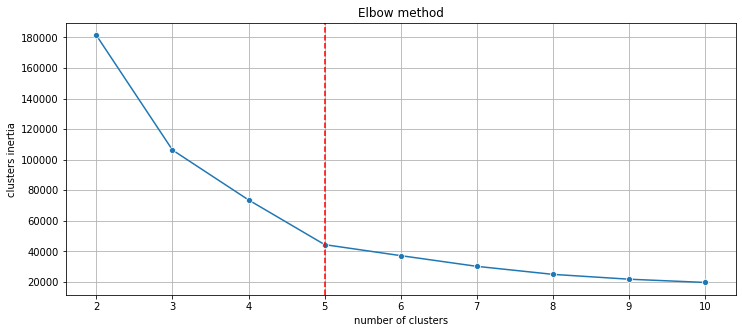

In [28]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(n_clusters, clusters_inertia, marker='o', ax=ax)
ax.set_title("Elbow method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("clusters inertia")
ax.axvline(5, ls="--", c="red")
plt.grid()
plt.show()

Dengan menggunakan elbow method, maka jumlah K yang disarankan yaitu 5, mari kita bandingan dengan silhoutte methode.

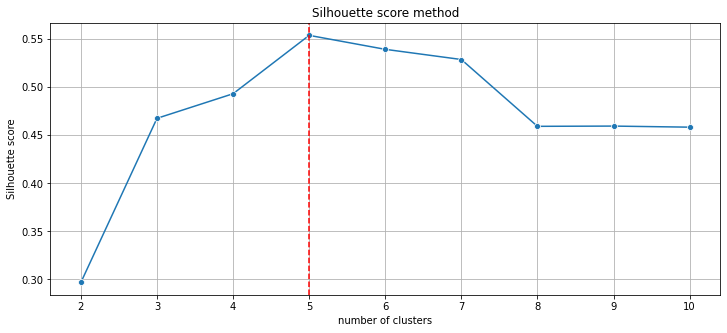

In [29]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(n_clusters, s_scores, marker='o', ax=ax)
ax.set_title("Silhouette score method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("Silhouette score")
ax.axvline(5, ls="--", c="red")
plt.grid()
plt.show()

In [30]:
x = df_customer.iloc[:,[3,4]].values 

For n_clusters = 2 The average silhouette_score is : 0.3273163942500746
For n_clusters = 3 The average silhouette_score is : 0.46761358158775435
For n_clusters = 4 The average silhouette_score is : 0.4931963109249047
For n_clusters = 5 The average silhouette_score is : 0.553931997444648
For n_clusters = 6 The average silhouette_score is : 0.5379675585622219
For n_clusters = 7 The average silhouette_score is : 0.5270287298101395
For n_clusters = 8 The average silhouette_score is : 0.4548653400650936
For n_clusters = 9 The average silhouette_score is : 0.4595491760122954
For n_clusters = 10 The average silhouette_score is : 0.4467356774401869


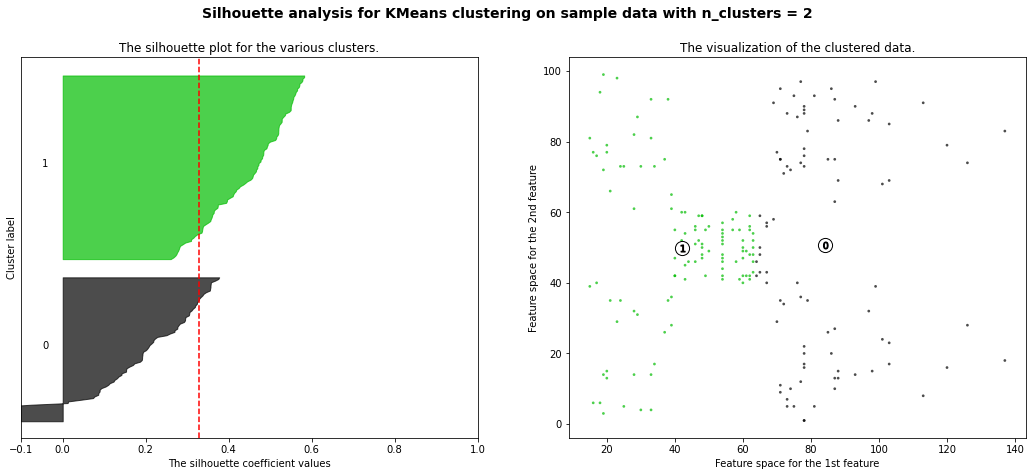

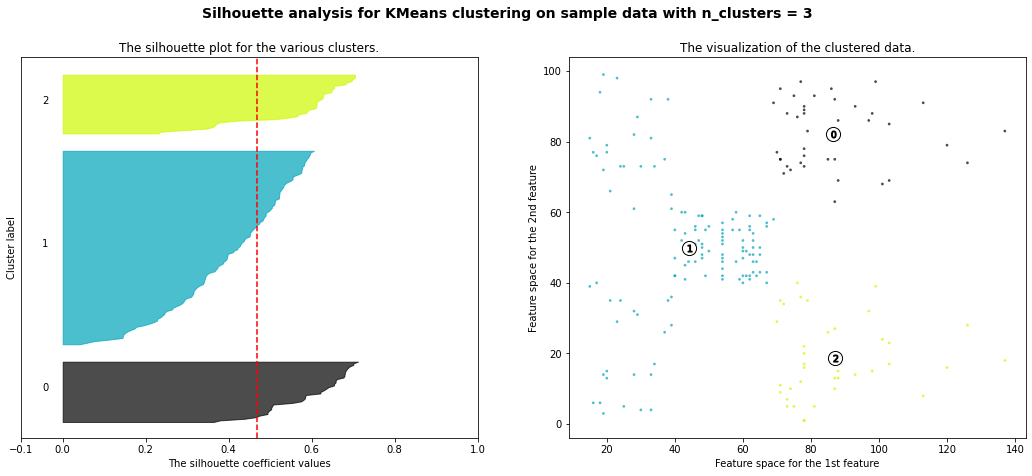

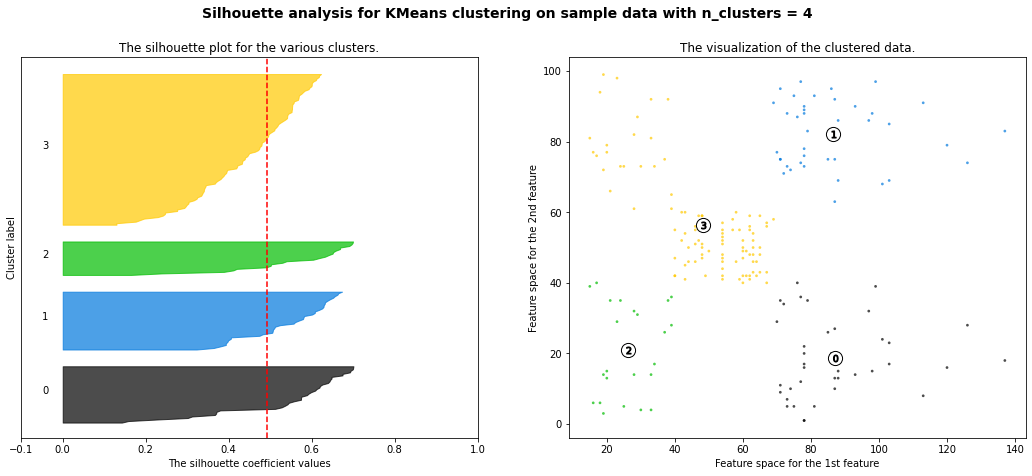

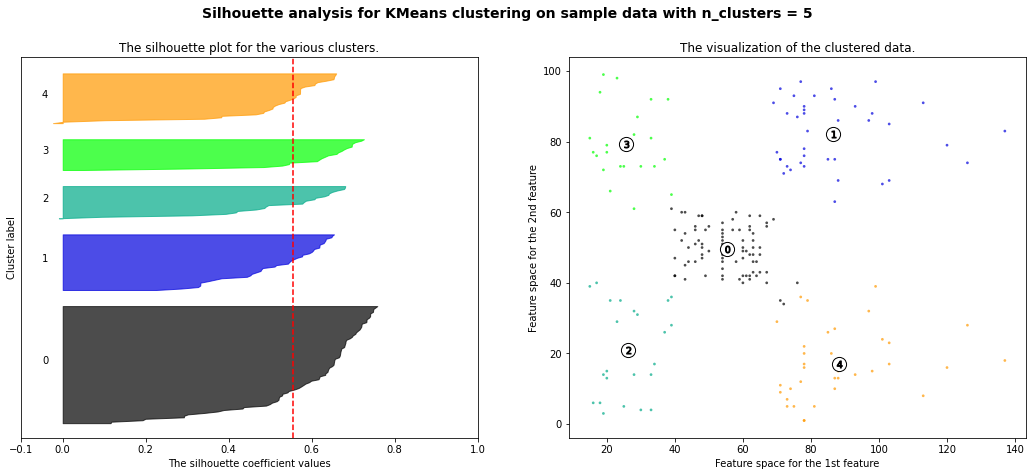

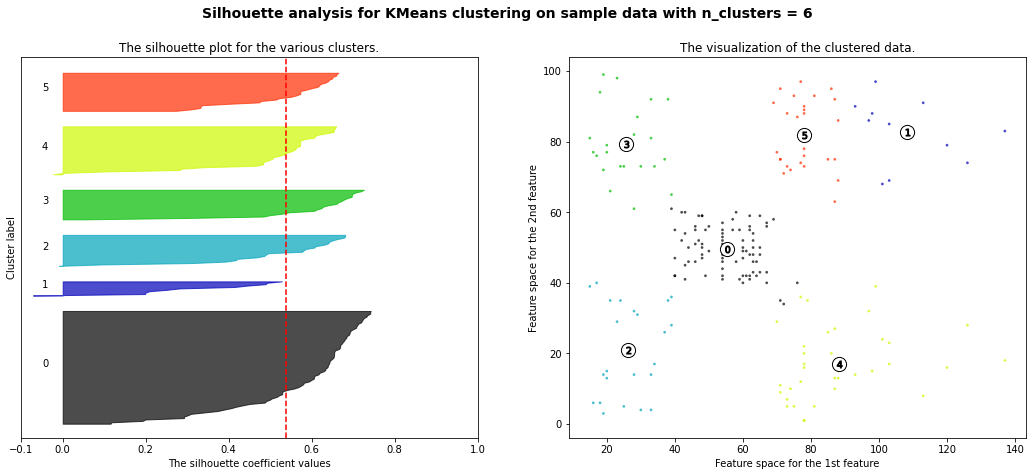

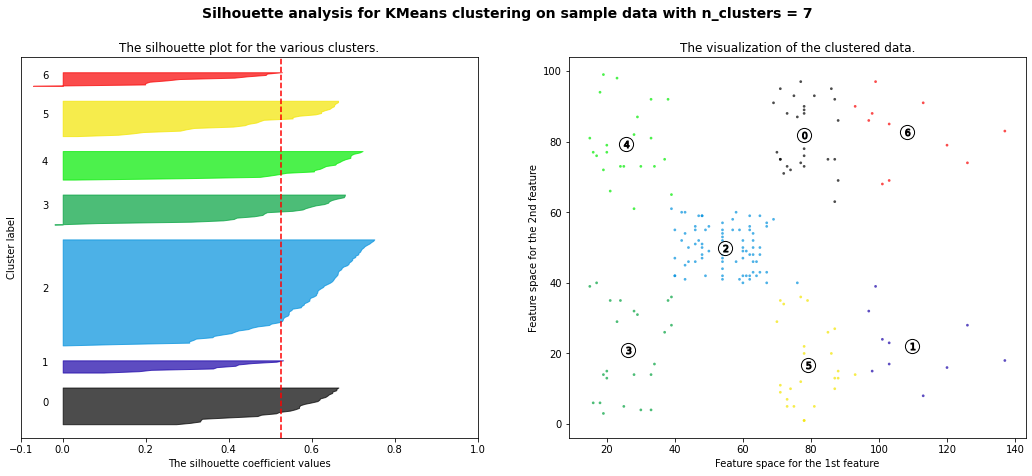

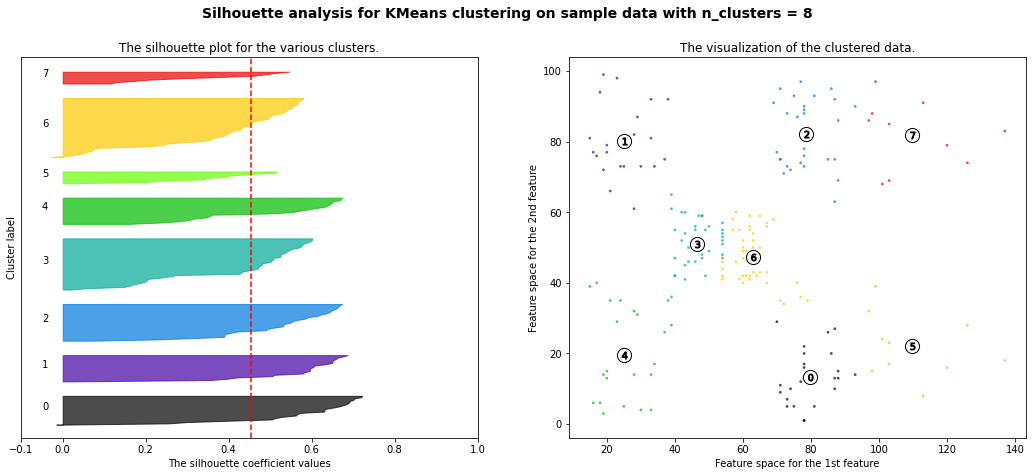

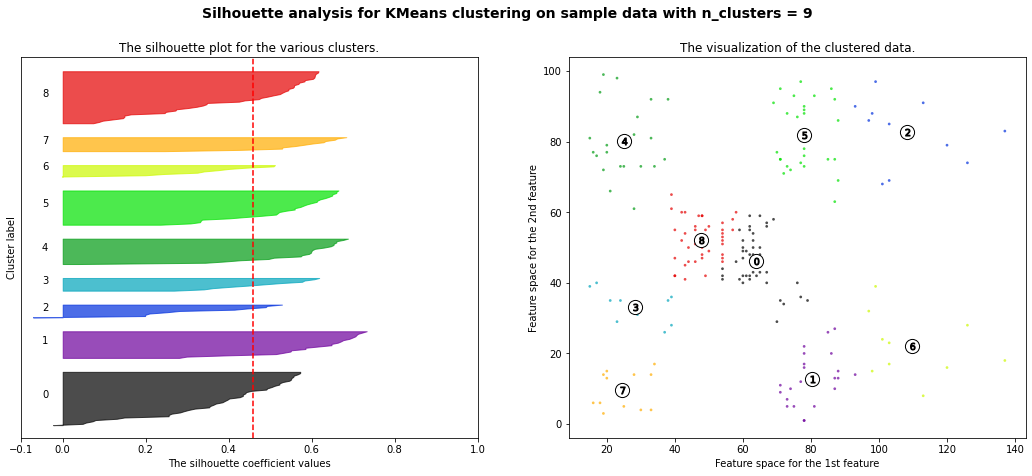

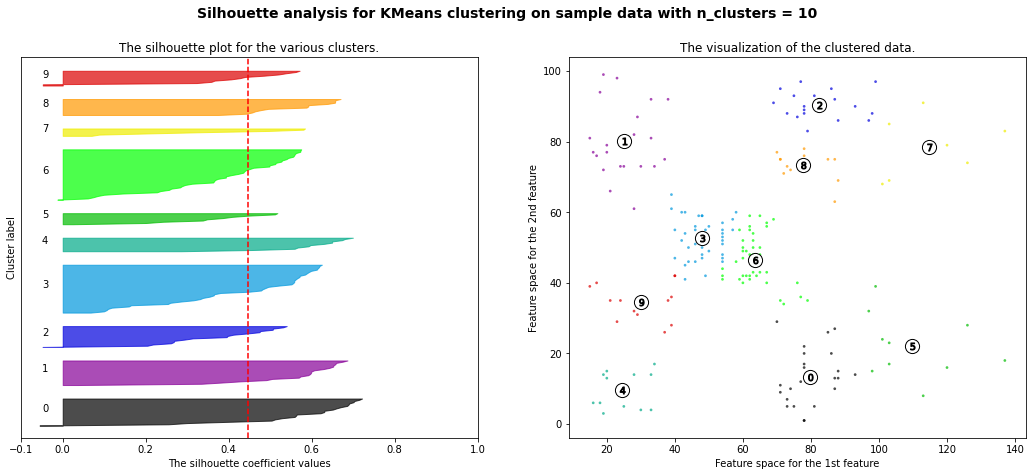

In [31]:
# Silhouette score (study the separation distance between the resulting clusters) 
# how close each point in one cluster is to points in the neighboring clusters 
# thus provides a way to assess parameters like number of clusters visually
import numpy as np

for n_clusters in range(2,11):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(x)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(x[:, 0], x[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

Silhouette score method juga mengindikasikan bahwa K optimal aalah 5. Maka kita akan menginput K=5 pada script .

In [32]:
#selecting feature (use iloc iloc as integer index-based. So here, we have to specify rows and columns by their integer index.)
# 2 Age, 3 column of income, 4 column of score 
Z_numerics = df_customer.iloc[:,[2,3,4]].values 

In [33]:
Z_numerics = df_customer[['age','income', 'score']] # subset with numerical only

In [34]:
KM_clusters = KMeans(n_clusters=5, init='k-means++').fit(Z_numerics) # initialise and fit K-Means model

KM_clustered = Z_numerics.copy()
KM_clustered.loc[:,'Cluster'] = KM_clusters.labels_ # append labels to points

Visualisasikan hasil kmeans dengan y axis = spending score, yang x axis = Annual
income dan age. Terlihat bahwa cluster dengan (x axis = annual income) lebih
terbentuk dibandingnya (x axis = age)

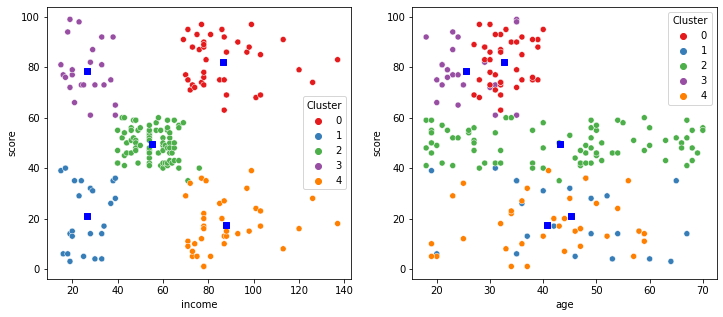

In [35]:
fig1, (axes) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot('income', 'score', data=KM_clustered,
                hue='Cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot('age', 'score', data=KM_clustered,
                hue='Cluster', palette='Set1', ax=axes[1], legend='full')

axes[0].scatter(KM_clusters.cluster_centers_[:,1],KM_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(KM_clusters.cluster_centers_[:,0],KM_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

Algoritma K-Means menghasilkan 5 cluster berikut:
- Cluster 0 konsumen annual income rendah dan spending score tinggi
- Cluster 1 konsumen dengan annual income tinggi dan spending score tinggi
- Cluster 2 konsumen dengan annual income sedang dan spending score
sedang
- Cluster 3 konsumen dengan annual income rendah dan spending score
rendah
- Cluster 4 konsumen dengan annual income tinggi dan spending score
rendah

Tidak ada kelompok yang berbeda dalam hal usia konsumen

In [36]:
#Sizes of the clusters:
KM_clust_sizes = KM_clustered.groupby('Cluster').size().to_frame()
KM_clust_sizes.columns = ["KM_size"]
KM_clust_sizes

,KM_size
Cluster,
0,39
1,23
2,79
3,23
4,36


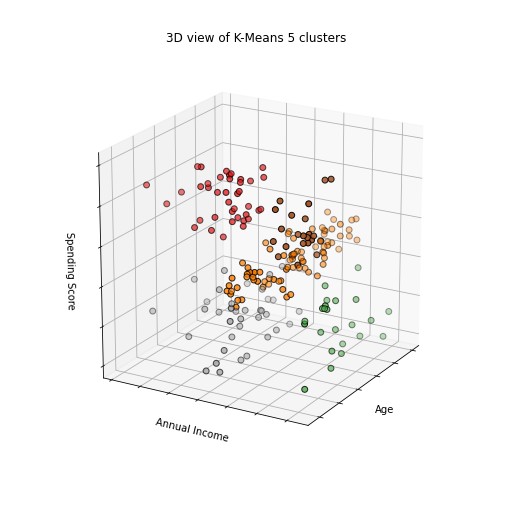

In [37]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7, 7))
ax = Axes3D(fig, rect=[0, 0, .99, 1], elev=20, azim=210)
ax.scatter(KM_clustered['age'],
           KM_clustered['income'],
           KM_clustered['score'],
           c=KM_clustered['Cluster'],
           s=35, edgecolor='k', cmap=plt.cm.Set1)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income')
ax.set_zlabel('Spending Score')
ax.set_title('3D view of K-Means 5 clusters')
ax.dist = 12

plt.show()

In [38]:
# Below a Plotly version:
import plotly as py
import plotly.graph_objs as go

def tracer(db, n, name):
    '''
    This function returns trace object for Plotly
    '''
    return go.Scatter3d(
        x = db[db['Cluster']==n]['age'],
        y = db[db['Cluster']==n]['score'],
        z = db[db['Cluster']==n]['income'],
        mode = 'markers',
        name = name,
        marker = dict(
            size = 5
        )
     )

trace0 = tracer(KM_clustered, 0, 'Cluster 0')
trace1 = tracer(KM_clustered, 1, 'Cluster 1')
trace2 = tracer(KM_clustered, 2, 'Cluster 2')
trace3 = tracer(KM_clustered, 3, 'Cluster 3')
trace4 = tracer(KM_clustered, 4, 'Cluster 4')

data = [trace0, trace1, trace2, trace3, trace4]

layout = go.Layout(
    title = 'Clusters by K-Means',
    scene = dict(
            xaxis = dict(title = 'Age'),
            yaxis = dict(title = 'Spending Score'),
            zaxis = dict(title = 'Annual Income')
        )
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

## DBSCAN 

Density-Based Spatial Clustering Algorithm with noise (DBSCAN) adalah
algoritma pengelompokan yang didasarkan pada kepadatan (density) data. Konsep
kepadatan dalam DBSCAN menghasilkan tiga macam status dari setiap data, yaitu inti
(core), batas (border), dan noise.

In [39]:
from sklearn.cluster import DBSCAN

In [40]:
#first create a matrix of investigated combinations.
from itertools import product

eps_values = np.arange(8,12.75,0.25) # eps values to be investigated
min_samples = np.arange(3,10) # min_samples values to be investigated
DBSCAN_params = list(product(eps_values, min_samples))

In [41]:
#Colecting number of generated clusters.
no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(Z_numerics)
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    sil_score.append(silhouette_score(Z_numerics, DBS_clustering.labels_))

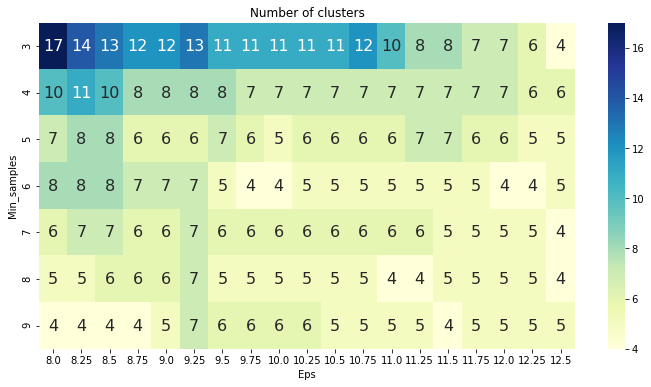

In [42]:
#A heatplot to shows how many clusters were genreated by the algorithm for the respective parameters combinations.
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
plt.show()

Seperti yang ditunjukkan heatplot di atas, jumlah cluster bervariasi dari 17 hingga 4.

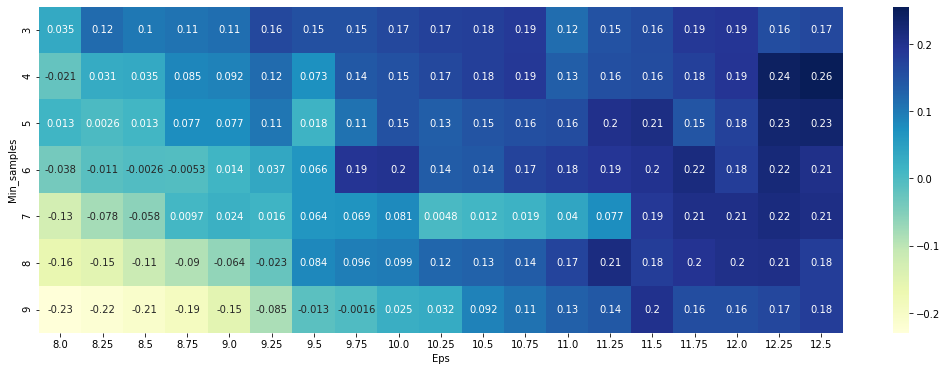

In [43]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

Global Maximum adalah 0,26 untuk eps = 12,5 dan min_samples = 4.


In [44]:
DBS_clustering = DBSCAN(eps=12.5, min_samples=4).fit(Z_numerics)

DBSCAN_clustered = Z_numerics.copy()
DBSCAN_clustered.loc[:,'Cluster'] = DBS_clustering.labels_ # append labels to points

In [45]:
DBSCAN_clust_sizes = DBSCAN_clustered.groupby('Cluster').size().to_frame()
DBSCAN_clust_sizes.columns = ["DBSCAN_size"]
DBSCAN_clust_sizes

,DBSCAN_size
Cluster,
-1,18
0,112
1,8
2,34
3,24
4,4


DBSCAN membuat 5 cluster ditambah cluster outlier (-1). Ukuran cluster 0-4
sangat bervariasi - beberapa hanya memiliki 4 atau 8 data.


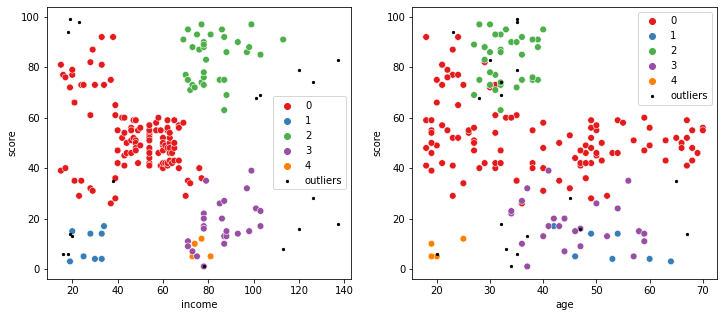

In [46]:
outliers = DBSCAN_clustered[DBSCAN_clustered['Cluster']==-1]

fig2, (axes) = plt.subplots(1,2,figsize=(12,5))


sns.scatterplot('income', 'score',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', ax=axes[0], palette='Set1', legend='full', s=45)

sns.scatterplot('age', 'score',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', palette='Set1', ax=axes[1], legend='full', s=45)

axes[0].scatter(outliers['income'], outliers['score'], s=5, label='outliers', c="k")
axes[1].scatter(outliers['age'], outliers['score'], s=5, label='outliers', c="k")
axes[0].legend()
axes[1].legend()
plt.setp(axes[0].get_legend().get_texts(), fontsize='10')
plt.setp(axes[1].get_legend().get_texts(), fontsize='10')

plt.show()

The graph above shows that there are some outliers - these points do not meet distance and minimum samples requirements to be recognised as a cluster.

## COMPARISON 


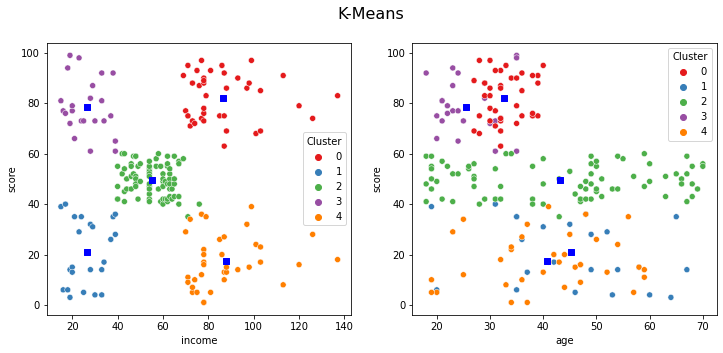

In [47]:
fig1.suptitle('K-Means', fontsize=16)
fig1

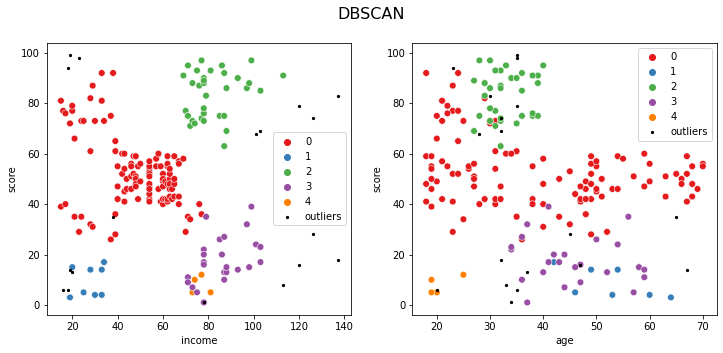

In [48]:
fig2.suptitle('DBSCAN', fontsize=16)
fig2

In [49]:
clusters = pd.concat([KM_clust_sizes, DBSCAN_clust_sizes],axis=1, sort=False)
clusters

,KM_size,DBSCAN_size
Cluster,,
-1,NaN,18
0,39.0,112
1,23.0,8
2,79.0,34
3,23.0,24
4,36.0,4


Dari perbandingan di atas, terlihat jelas bahwa DBSCAN gagal menghasilkan
cluster yang wajar. Ini karena masalah dalam mengenali cluster dengan berbagai
kepadatan (dalam dataset ini).Kmeans menciptakan cluster yang baik, berjumlah 5.